In [99]:
import aplpy
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys
from numpy.random import rand,seed
from pylab import *

In [3]:
sys.path.insert(1, '/Users/hannahkoziol/Dropbox/Research/python_modules/plfit')
import plfit

In [117]:
#LOADING IN DATA FILES
after_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_000_clean14_1_pbcor.fits')
before_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_000.fits')
after_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_051_clean14_pbcor.fits')
before_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_051.fits')
after_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_000_clean14_pbcor.fits')
before_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_000.fits')
after_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_066_clean14_pbcor.fits')
before_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits')
noise_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_000_clean14_1_noise_finalfwhm.fits')
noise_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_051_clean14_noise_finalfwhm.fits')
noise_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_000_clean14_noise_finalfwhm.fits')
noise_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_066_clean14_noise_finalfwhm.fits')

In [27]:
#SIMULATED OBSERVATIONAL DATA
def simulated_data_retrieval(sim_self):
    sim_self = sim_self[0].data
    column_density_array_after = sim_self
    flat_column_density_array_after = column_density_array_after.flatten()
    return flat_column_density_array_after

In [28]:
#ORIGINAL SIMULATION DATA
def original_data_retrieval(snap_self):
    snap_self = snap_self[0].data * 10
    column_density_array_before = snap_self / (1e4)
    flat_column_density_array_before = column_density_array_before.flatten()
    return flat_column_density_array_before

In [49]:
#CREATING HISTOGRAMS AND SPLINE INPUTS
def histogram_before_fit(column_density_before, column_density_after):
    fig, ax = plt.subplots()
    plt.hist(column_density_before, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "Before Observation and Cleaning", color='firebrick', alpha=0.99)
    before_hist = plt.hist(column_density_before, bins=np.logspace(22, 23.5, 30), log=True, color='firebrick', alpha=0.3)
    plt.hist(column_density_after, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "After Observation and Cleaning", color='cornflowerblue', alpha=0.99)
    after_hist = plt.hist(column_density_after, bins=np.logspace(22, 23.5, 30), log=True, color='cornflowerblue', alpha=0.3)
    ax.set_xscale('log')
    plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Frequency$')
    plt.legend(loc = 'lower left')
    plt.close()
    
    before_x = before_hist[1]
    before_mid = [(a + b) /2 for a,b in zip(before_x[:-1], before_x[1:])]
    before_y = before_hist[0]
    x_before_x = np.array(before_mid)
    y_before_y = np.array(before_y)

    after_x = after_hist[1]
    after_mid = [(a + b) /2 for a,b in zip(after_x[:-1], after_x[1:])]
    after_y = after_hist[0]
    x_after_x = np.array(after_mid)
    y_after_y = np.array(after_y)
    
    return x_before_x, y_before_y, x_after_x, y_after_y

In [105]:
#COMBINING THESE FUNCTIONS
def histogram_harvesting(before_data, after_data):
    after_data_flat_array = simulated_data_retrieval(after_data)
    before_data_flat_array = original_data_retrieval(before_data)
    return histogram_before_fit(before_data_flat_array, after_data_flat_array)

In [106]:
#SPLINE FITTING ROUTINE
def spline_method(x_data, y_data):
    spl = UnivariateSpline(x_data, np.log(y_data), k = 1, s = .03)
    x_num_array = np.linspace(min(x_data), max(x_data), 500)
    deriv = spl.derivative(1)

    plt.plot(x_data, y_data, label = 'Data' )
    plt.plot(x_num_array, np.exp(spl(x_num_array)), label = 'Fit', linestyle = ':', color = 'red')
    plt.legend()
    plt.show()
    
    plt.plot(x_num_array, deriv(x_num_array), label = '1st Derivative')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    max_deriv = deriv(x_num_array)[1]
    x_min_value = x_num_array[np.argwhere(deriv(x_num_array) < max_deriv)][0]
    
    
    return x_min_value

In [135]:
#ADDING FIT LINE
def plotpdf(self,x=None,xmin=None,alpha=None,nbins=30,dolog=True,dnds=False,
            drawstyle='steps-post', histcolor='k', plcolor='r', **kwargs):
        """
        Plots PDF and powerlaw.

        kwargs is passed to pylab.hist and pylab.plot
        """
        if not(x): x=self.data
        if not(xmin): xmin=self._xmin
        if not(alpha): alpha=self._alpha

        x=np.sort(x)
        n=len(x)

        plt.gca().set_xscale('log')
        plt.gca().set_yscale('log')

        if dnds:
            hb = plt.hist(x,bins=np.logspace(log10(min(x)),log10(max(x)),nbins, histtype = 'step'))
            h = hb[0]
            b = hb[1]
            db = hb[1][1:]-hb[1][:-1]
            h = h/db
            plt.plot(b[:-1],h,drawstyle=drawstyle,color=histcolor,**kwargs)
            #alpha -= 1
        elif dolog:
            hb = plt.hist(x,bins=np.logspace(log10(min(x)),log10(max(x)),nbins),log=True,fill=False,edgecolor='none', histtype = 'step', **kwargs)
            alpha -= 1
            h,b=hb[0],hb[1]
        else:
            hb = plt.hist(x,bins=np.linspace((min(x)),(max(x)),nbins),fill=False,edgecolor='none', histtype = 'none', **kwargs)
            h,b=hb[0],hb[1]
        # plotting points are at the center of each bin
        b = (b[1:]+b[:-1])/2.0

        q = x[x>=xmin]
        px = (alpha-1)/xmin * (q/xmin)**(-alpha)

        # Normalize by the median ratio between the histogram and the power-law
        # The normalization is semi-arbitrary; an average is probably just as valid
        plotloc = (b>xmin)*(h>0)
        norm = np.median( h[plotloc] / ((alpha-1)/xmin * (b[plotloc]/xmin)**(-alpha))  )
        px = px*norm

        plotx = np.linspace(q.min(),q.max(),1000)
        ploty = (alpha-1)/xmin * (plotx/xmin)**(-alpha) * norm

        #pylab.loglog(q,px,'r',**kwargs)
        plt.loglog(plotx,ploty,color=plcolor,**kwargs)

        axlims = plt.axis()
        plt.vlines(xmin,axlims[2],max(px),colors=plcolor,linestyle='dashed')

        plt.gca().set_xlim(min(x),max(x))

In [136]:
#USING PLFIT
def plfit_method(column_density_array, xmin_value):
    myplfit = plfit.plfit(column_density_array[(column_density_array>=1e22)], xmin = xmin_value, discrete = False, usefortran=False)
    print('Fitting done')
    figure(1)
    myplfit.plotpdf()
    ax = plt.gca()
    #ax.set_xlim(1e22, 4e23)
    #ax.set_ylim(0.5, 8e3)
    print('Plot 1 done')
    figure(2)
    myplfit.plotcdf()
    print('Plot 2 done')
    figure(3)
    myplfit.plotppf()
    print('Plot 3 done')
    return myplfit

In [137]:
#GETTING SIGMA DATA
def sigma_retrieval(noise_file):
    sigma_data = noise_file[0].data
    flat_sigma_data = sigma_data.flatten()
    sigma_value = np.median(flat_sigma_data)
    three_sigma_value = 3 * np.median(flat_sigma_data)
    return three_sigma_value

In [152]:
#PLOTTING FINAL HISTOGRAM
def final_histogram(column_density_before, column_density_after, sigma_file, title):
    fig, ax = plt.subplots()
    plt.hist(column_density_before, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "Before Observation and Cleaning", color='firebrick', alpha=0.99)
    plt.hist(column_density_before, bins=np.logspace(22, 23.5, 30), log=True, color='firebrick', alpha=0.3)
    plt.hist(column_density_after, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "After Observation and Cleaning", color='cornflowerblue', alpha=0.99)
    plt.hist(column_density_after, bins=np.logspace(22, 23.5, 30), log=True, color='cornflowerblue', alpha=0.3)
    plt.axvline(sigma_retrieval(sigma_file), label = r'3 $\sigma$', linestyle = ':', color = 'olive')
    ax.set_xscale('log')
    plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Frequency$')
    ax.set_title(title)
    plt.legend(loc = 'lower left')
    plotpdf(myplfit_before, plcolor='firebrick')
    plotpdf(myplfit_after, plcolor='cornflowerblue')
    plt.text(8e22, 5e3, r'$\alpha = 4.84754 \pm $' + str(myplfit_before._alpha), horizontalalignment = 'left', color = 'firebrick')
    plt.text(8e22, 2e3, r'$\alpha = 6.54487 \pm $' + str(myplfit_after._alpha), horizontalalignment = 'left', color = 'cornflowerblue')
    plt.xlim(1e22, 3e23)
    plt.show()

In [107]:
histogram_harvesting(before_B1_000, after_B1_000)
x_before_x = histogram_harvesting(before_B1_000, after_B1_000)[0]
y_before_y = histogram_harvesting(before_B1_000, after_B1_000)[1]
x_after_x = histogram_harvesting(before_B1_000, after_B1_000)[2]
y_after_y = histogram_harvesting(before_B1_000, after_B1_000)[3]

In [95]:
print(y_after_y)

[ 568.  638.  836. 1082. 1444. 1831. 2354. 3151. 4188. 5114. 5996. 6591.
 6896. 6582. 5749. 4000. 2467. 1559.  901.  388.  130.   28.    7.    0.
    0.    0.    0.    0.    0.]


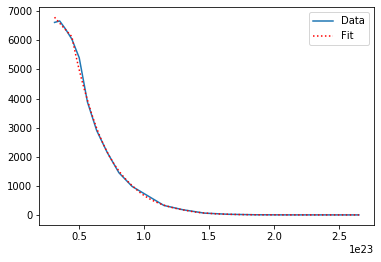

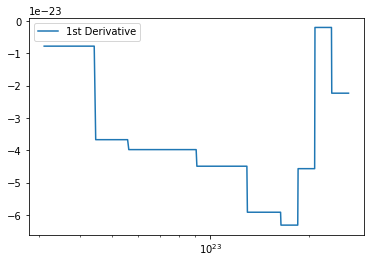

4.464995515365419e+22


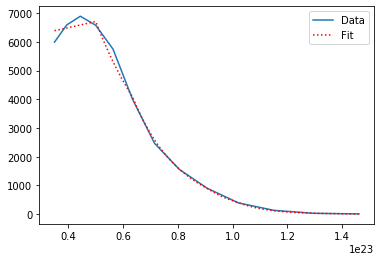

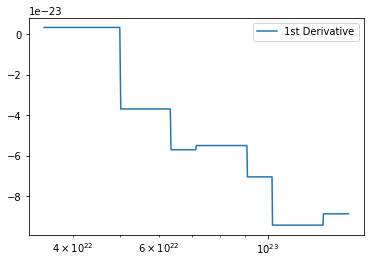

5.012229612489177e+22


In [98]:
x_min_before = spline_method(x_before_x[9:-1], y_before_y[9:-1])[0]
print(x_min_before)

x_min_after = spline_method(x_after_x[10:-6], y_after_y[10:-6])[0]
print(x_min_after)

xmin: 4.465e+22 n(>xmin): 20586 alpha: 4.29934 +/- 0.0229954   Log-Likelihood: -1.07588e+06   ks: 0.0463261 p(ks): 3.93162e-39
Fitting done
Plot 1 done
Plot 2 done
Plot 3 done


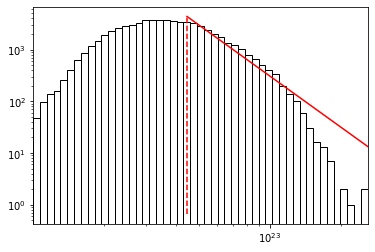

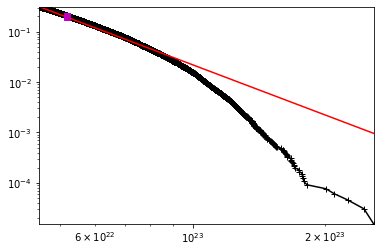

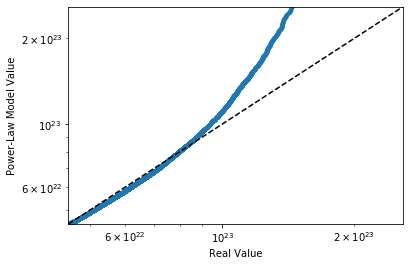

In [120]:
flat_column_density_array_before = original_data_retrieval(before_B1_000)
myplfit_before = plfit_method(flat_column_density_array_before, x_min_before)

xmin: 5.01223e+22 n(>xmin): 18255 alpha: 5.37011 +/- 0.0323446   Log-Likelihood: -949676   ks: 0.0652472 p(ks): 2.6027e-68
Fitting done
Plot 1 done
Plot 2 done
Plot 3 done


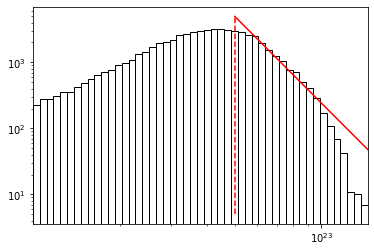

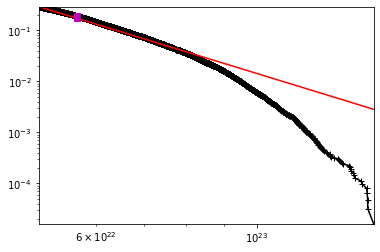

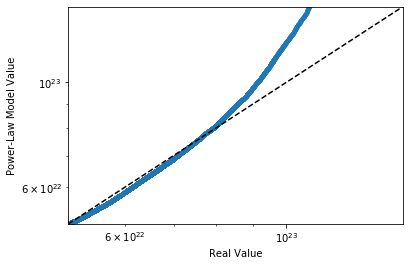

In [124]:
flat_column_density_array_after = simulated_data_retrieval(after_B1_000)
myplfit_after = plfit_method(flat_column_density_array_after, x_min_after)

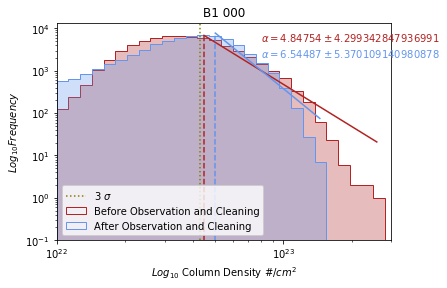

In [153]:
final_histogram(flat_column_density_array_before, flat_column_density_array_after, noise_B1_000, 'B1 000')